In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

import sncosmo
#from sed import SED
from ztf_supernova import load_sn
from gp_fit import fit_gp_model, gp_predict

%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "P052"
plt.rcParams['mathtext.fontset'] = "cm"

In [2]:
from astropy.table import Table
from sncosmo.utils import alias_map
from sncosmo.photdata import PHOTDATA_ALIASES, PHOTDATA_REQUIRED_ALIASES

In [213]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

import sncosmo
from functools import partial

class SED(object):
    """Creates a Spectral Energy Distribution (SED) object from
    an sncosmo source.
    """
    def __init__(self, 
                 source: str, 
                 z: float, 
                 mwebv: float = 0.0, 
                 phase_range: tuple[float, float] = (-10, 90), 
                 bands: list = ['ztf::g', 'ztf::r', 'ztf::i'],
                 **kwargs: dict):
        """
        Parameters
        ----------
        source: sncosmo source.
        z: redshift.
        mwebv: Milky-Way dust extinction.
        """
        self.source = source
        self.z = z
        self.mwebv = mwebv
        # load model and set parameters
        self.load_model(source)
        params_dict = {"z":z, "mwebv":mwebv} | kwargs
        self.set_parameters(**params_dict)
        # set bands and plot params
        self.bands = bands
        self._set_wavelength_coverage()
        self.colours = {'ztf::g':"green", 'ztf::r':"red", 'ztf::i':"gold"}
        # time range
        self.phase_range = phase_range
        step = 0.1
        self.times = np.arange(self.phase_range[0], 
                               self.phase_range[1] + step,
                               step
                              )
    
    def load_model(self, source, mw_dust_law: sncosmo.PropagationEffect = None) -> sncosmo.models.Model:
        """Loads the SED model from an sncosmo Source.
        """
        self.model = sncosmo.Model(source=self.source)
        # Milky-Way dust law
        if mw_dust_law is None:
            mw_dust_law = sncosmo.CCM89Dust()
        self.model.add_effect(mw_dust_law, 'mw', 'obs')

    def set_parameters(self, **kwargs):
        """Sets model parameters.
        """
        self.rest_model = deepcopy(self.model)  # model @ z=0, without corrections
        self.model.set(**kwargs)
    
    def _set_wavelength_coverage(self):
        bands_wave = np.empty(0)
        for band in self.bands:
            bands_wave = np.r_[bands_wave, sncosmo.get_bandpass(band).wave]
        self.minwave = bands_wave.min()
        self.maxwave = bands_wave.max()

    def plot_lightcurves(self, zp: float = 30, zpsys = 'ab', restframe: bool = False):
        """Plots the model light curves.
        """
        # chose between observer- and rest-frame model
        if restframe is True:
            model = self.rest_model
        else:
            model = self.model
        # plot light curves
        fig, ax = plt.subplots(figsize=(6, 4))
        for band, colour in self.colours.items():
            flux = model.bandflux(band, self.times, zp=zp, zpsys=zpsys)
            mag = -2.5 * np.log10(flux) + zp
            ax.plot(self.times, mag, label=band, color=colour)
        # config
        plt.gca().invert_yaxis()
        ax.set_xlabel('Days since B-maximum', fontsize=16)
        ax.set_ylabel('Apparent Magnitude', fontsize=16)
        ax.set_title(f'"{self.source}" SED source (z={self.z})', fontsize=16)
        ax.tick_params('both', labelsize=14)
        ax.legend(fontsize=14)
        plt.tight_layout()
        plt.show()

    def plot_sed(self, phase: float = 0.0, minwave: float = None, maxwave: float = None):
        """Plots the SED model at a given phase.
        """
        phase = np.array(phase)
        if minwave is None:
            minwave = self.minwave
        if maxwave is None:
            maxwave = self.maxwave
        # get flux
        rest_wave = np.arange(self.rest_model.minwave(), self.rest_model.maxwave() )
        rest_flux = self.rest_model.flux(phase, rest_wave)
        wave = np.arange(self.model.minwave(), self.model.maxwave())
        flux = self.model.flux(phase, wave)
        # plot SED
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(rest_wave, rest_flux, label="Rest-frame")
        ax.plot(wave, flux, label="Observer-frame")
        # plot filters
        ax2 = ax.twinx() 
        for band in self.bands:
            band_wave = sncosmo.get_bandpass(band).wave
            band_trans = sncosmo.get_bandpass(band).trans
            ax2.plot(band_wave, band_trans, color=self.colours[band], alpha=0.4)
        # config
        ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=16)
        ax.set_ylabel(r'$F_{\lambda}$', fontsize=16)
        ax.set_title(f'"{self.source}" SED source (z={self.z})', fontsize=16)
        ax.tick_params('both', labelsize=14)
        ax.set_xlim(minwave, maxwave)
        ax2.set_ylim(None, 8)
        ax2.set_yticks([])
        ax.legend(fontsize=14)
        plt.tight_layout()
        plt.show()

    def plot_kcorr(self, zp: float = 30, zpsys: str = 'ab'):
        """Plots the same-filter K-correction.
        """
        fig, ax = plt.subplots(figsize=(6, 4))
        for band, colour in self.colours.items():
            rest_flux = self.rest_model.bandflux(band, self.times, zp=zp, zpsys=zpsys)
            flux = self.model.bandflux(band, self.times, zp=zp, zpsys=zpsys) 
            kcorr = -2.5 * np.log10(rest_flux / flux)
            ax.plot(self.times, kcorr, label=band, color=colour)
        
        ax.set_xlabel('Days since B-maximum', fontsize=16)
        ax.set_ylabel(r'$K$-correction (mag)', fontsize=16)
        ax.set_title(f'"{self.source}" SED source (z={self.z})', fontsize=16)
        ax.tick_params('both', labelsize=14)
        ax.legend(fontsize=14)
        plt.tight_layout()
        plt.show()

class Photometry(object):
    """Creates a photometry object to handle observations.
    """
    def __init__(self, data: str | pd.DataFrame | Table):
        """
        Parameters
        ----------
        data: supernova photometry.
        """
        if isinstance(data, str):
            data = pd.read_csv(data)
        elif isinstance(data, Table):
            data = data.to_pandas()
        
        # taken from sncosmo
        mapping = alias_map(data.columns, 
                            PHOTDATA_ALIASES,
                            required=PHOTDATA_REQUIRED_ALIASES)

        self.time = np.asarray(data[mapping['time']])
        self.band = data[mapping['band']].values
        self.eff_wave = np.array([sncosmo.get_bandpass(band).wave_eff 
                                  for band in self.band])

        self.flux = np.asarray(data[mapping['flux']])
        self.flux_err = np.asarray(data[mapping['fluxerr']])
        self.zp = np.asarray(data[mapping['zp']])
        self.zpsys = np.asarray(data[mapping['zpsys']])


class Refiner(object):
    """Object for building a colour-matched SED model.
    """
    def __init__(self, 
                 data: str | pd.DataFrame | Table,
                 source: str,
                 z: float,
                 mwebv: float = 0.0, 
                 phase_range: tuple[float, float] = (-10, 90),
                ):
        """
        Parameters
        ----------
        data: supernova photometry in sncosmo format.
        source: sncosmo source.
        z: redshift.
        mwebv: Milky-Way dust extinction.
        phase_range: phase range to be used for the SED model. 
        """
        self.source = source
        self.z = z
        self.mwebv = mwebv
        self.phase_range = phase_range
        self.phot = Photometry(data)
        self.bands = np.unique(self.phot.band)
        self.sed = SED(source, z, mwebv, phase_range, np.unique(self.bands))
        
    def _setup_phase(self, t0: float):
        """Loads the photometry of a supernova.
        """
        self.phot.phase = (self.phot.time - t0) / (1 + self.sed.z)

    def match_sed(self, t0: float, k1: str = 'ExpSquared', fit_mean: bool = True):
        """Modifies the SED model to match the observations using Gaussian Process (GP) regression.

        Parameters
        ----------
        t0: time of reference (e.g. optical peak).
        k1: GP kernel for the time axis.
        fit_mean: whether to fit a mean function (constant).
        """
        # select phase range
        self._setup_phase(t0)
        minphase, maxphase = self.phase_range
        self.phase_mask = (minphase <= self.phot.phase) & (self.phot.phase <= maxphase)
        # flux ratios
        model_flux = self.sed.model.bandflux(self.phot.band, 
                                             self.phot.phase,
                                             zp=self.phot.zp, 
                                             zpsys=self.phot.zpsys)
        self.ratio_flux = self.phot.flux / model_flux
        self.ratio_error = self.phot.flux_err / model_flux
        # fit mangling surface
        self.gp_model = fit_gp_model(self.phot.phase[self.phase_mask], 
                                     self.phot.eff_wave[self.phase_mask], 
                                     self.ratio_flux[self.phase_mask], 
                                     self.ratio_error[self.phase_mask], 
                                     k1=k1, fit_mean=fit_mean)
        self.gp_predict = partial(gp_predict, 
                                  ratio_pred=self.ratio_flux[self.phase_mask],
                                  error_pred=self.ratio_error[self.phase_mask],
                                  gp_model=self.gp_model,
                                 )

    def plot_fit(self):
        """Plots the light-curve fit and ratio between the observations and SED.
        """
        # phase range to use
        minphase, maxphase = self.phase_range
        pred_phase = np.arange(minphase, maxphase + 0.1, 0.1)
        
        fig, ax = plt.subplots(2, 1, height_ratios=(3, 1), gridspec_kw={"hspace":0})
        for band in self.bands:
            band_mask = self.phot.band == band
            mask = self.phase_mask & band_mask
            # apply mask
            phase = self.phot.phase[mask]
            flux, flux_err = self.phot.flux[mask], self.phot.flux_err[mask]
            zp, zpsys = self.phot.zp[mask], self.phot.zpsys[mask]
            eff_wave = sncosmo.get_bandpass(band).wave_eff
            # ratios
            ratio_flux = self.ratio_flux[mask]
            ratio_error = self.ratio_error[mask]
            
            ########################
            # observer-frame model #
            ########################            
            pred_obs_wave = np.array([eff_wave] * len(pred_phase))
            obs_ratio_fit, obs_var_fit = self.gp_predict(pred_phase, pred_obs_wave)
            obs_std_fit = np.sqrt(obs_var_fit)
            # apply K-correction
            obs_model_flux = self.sed.model.bandflux(band, pred_phase, zp=zp[0], zpsys=zpsys[0])
            obs_kcorr_flux = obs_model_flux * obs_ratio_fit
            obs_kcorr_error = obs_model_flux * obs_std_fit
            
            ####################
            # rest-frame model #
            ####################
            pred_rest_wave = np.array([eff_wave * (1 + self.z)] * len(pred_phase))
            rest_ratio_fit, rest_var_fit = self.gp_predict(pred_phase, pred_rest_wave)
            rest_std_fit = np.sqrt(rest_var_fit)
            # apply K-correction
            rest_model_flux = self.sed.rest_model.bandflux(band, pred_phase, zp=zp[0], zpsys=zpsys[0])
            rest_kcorr_flux = rest_model_flux * rest_ratio_fit
            rest_kcorr_error = rest_model_flux * rest_std_fit

            ########
            # Plot #
            ########
            colour = self.sed.colours[band]
            # data
            ax[0].errorbar(phase, flux, flux_err, ls="", marker="o", color=colour, label=band)
            # model
            #ax[0].plot(pred_phase, rest_kcorr_flux, color=colour, ls='dotted')
            ax[0].plot(pred_phase, obs_kcorr_flux, color=colour)
            ax[0].fill_between(pred_phase, 
                               obs_kcorr_flux - rest_kcorr_error, 
                               obs_kcorr_flux + rest_kcorr_error, 
                               alpha=0.2,
                               color=colour)
        
            # residuals
            norm = np.average(ratio_flux, weights=1 / ratio_error ** 2)  # for plotting only
            # ratio
            ax[1].errorbar(phase, ratio_flux / norm, ratio_error / norm, 
                           ls="", marker="o", color=colour)
            # fit
            ax[1].plot(pred_phase, obs_ratio_fit / norm, color=colour)
            ax[1].fill_between(pred_phase, 
                               (obs_ratio_fit - obs_std_fit) / norm, 
                               (obs_ratio_fit + obs_std_fit) / norm, 
                               alpha=0.2, color=colour)
            
            # config
            ax[0].set_ylabel(r'$F_{\lambda}$', fontsize=16)
            ax[1].set_xlabel('Days since B-maximum', fontsize=16)
            ax[1].set_ylabel(r'$F_{\lambda}^{\rm data} / F_{\lambda}^{\rm SED}$', fontsize=16)
            ax[0].set_title(f'"{self.source}" SED source (z={self.z})', fontsize=16)
            for i in range(2):
                ax[i].tick_params('both', labelsize=14)
        ax[0].legend(fontsize=14)
        plt.show()

    def calculate_colour(self, band1: str, band2: str, zp: float = 30, zpsys: str = 'ab', 
                         plot: bool = True):
        """Calculates rest-frame colour using the colour-matched SED.

        Note: Colour = band1 - band2
        
        Parameters
        ----------
        band1: First band.
        band2: Second band.
        zp: Zeropoint for both bands. Only used if the photometry does not 
            include any of the given bands.
        zpsys: Magnitude system for both bands. Only used if the photometry
            does not  include any of the given bands.
        plot: Whether to plot the colour curve.

        Results
        -------
        colour: Colour curve.
        colour_err: Uncertainty.
        """
        # phase range to use
        minphase, maxphase = self.phase_range
        pred_phase = np.arange(minphase, maxphase + 0.1, 0.1)
        self.pred_phase = pred_phase

        if (band1 not in self.phot.band) | (band2 not in self.phot.band):
            eff_wave1 = sncosmo.get_bandpass(band1).wave_eff
            eff_wave2 = sncosmo.get_bandpass(band2).wave_eff
            zp1 = zp2 = zp
            zpsys1 = zpsys2 = zpsys
        else:
            # create band and phase mask
            band_mask1 = self.phot.band == band1
            band_mask2 = self.phot.band == band2
            mask1 = self.phase_mask & band_mask1
            mask2 = self.phase_mask & band_mask2
            # apply mask
            eff_wave1 = self.phot.eff_wave[mask1][0]
            eff_wave2 = self.phot.eff_wave[mask2][0]
            zp1 = self.phot.zp[mask1][0]
            zp2 = self.phot.zp[mask2][0]
            zpsys1 = self.phot.zpsys[mask1][0]
            zpsys2 = self.phot.zpsys[mask2][0]
        
        # wavelength array
        pred_wave = np.array([eff_wave1 * (1 + self.z)] * len(pred_phase) + 
                             [eff_wave2 * (1 + self.z)] * len(pred_phase) 
                            )
        # flux array
        rest_model_flux1 = self.sed.rest_model.bandflux(band1, pred_phase, zp=zp1, zpsys=zpsys1)
        rest_model_flux2 = self.sed.rest_model.bandflux(band2, pred_phase, zp=zp2, zpsys=zpsys2)
        rest_model_flux = np.r_[rest_model_flux1, rest_model_flux2]
        # K-corr. predict
        pred_phase_ = np.r_[pred_phase, pred_phase]
        ratio_fit, cov_fit = self.gp_predict(pred_phase_, pred_wave, return_cov=True)
        rest_kcorr_flux = rest_model_flux * ratio_fit
        rest_kcorr_cov = np.outer(rest_model_flux, rest_model_flux) * cov_fit
        self.colour_flux_ratio = rest_kcorr_flux
        self.colour_flux_cov = rest_kcorr_cov
        
        # compute flux ratio for the colour
        colour, colour_err = self._compute_colour(rest_kcorr_flux, rest_kcorr_cov, zp1, zp2)
        self.colour, self.colour_err = colour, colour_err
        self._compute_colour_stretch()

        if plot is True:
            fig, ax = plt.subplots()
            ax.plot(pred_phase, colour)
            ax.fill_between(pred_phase, colour - colour_err, colour + colour_err, 
                            alpha=0.2)
            ax.set_ylabel(fr'$({band1} - {band2})$ (mag)', fontsize=16)
            ax.set_xlabel('Days since B-maximum', fontsize=16)
            ax.set_title(f'"{self.source}" SED source (z={self.z})', fontsize=16)
            ax.tick_params('both', labelsize=14)
            plt.show()

    def _compute_colour(self, fluxes: np.ndarray, cov: np.ndarray, 
                        zp1: float | np.ndarray, zp2: float | np.ndarray):
        """Computes the colour curve from concatenated flux arrays from two bands.

        Note: flux = [flux1_0, flux1_1, ...flux1_N, # band1
                      flux2_N+1, flux2_N+2, ...flux2_2N]  # band2
        Parameters
        ----------
        flux: Flux from two bands.
        cov: Covariance from two bands.
        zp1: Zero point of first band.
        zp2: Zero point of second band.
        """
        N = fluxes.shape[0] // 2
        f1 = fluxes[:N]
        f2 = fluxes[N:]
        # variance and covariance
        cov_11 = cov[:N, :N]
        cov_22 = cov[N:, N:]
        cov_12 = cov[:N, N:]
        
        # error propagation
        prefactor = 2.5 / np.log(10)
        var_colour = (
            (np.diag(cov_11) / (f1 ** 2)) +
            (np.diag(cov_22) / (f2 ** 2)) -
            2 * np.diag(cov_12) / (f1 * f2)
        ) * (prefactor ** 2)

        colour = -2.5 * np.log10(f1 / f2) + (zp1 - zp2)
        colour_err = np.sqrt(var_colour)
    
        return colour, colour_err

    def _compute_colour_stretch(self):
        # colour-stretch between 0.4 and 1.4 translate to phases between 12 and 42 days
        # assuming sBV...
        mask = (12 < self.pred_phase) & (self.pred_phase < 42)  
        pred_phase = self.pred_phase[mask]
        mask = np.array(list(mask) + list(mask))
        fluxes = np.random.multivariate_normal(self.colour_flux_ratio[mask], 
                                               self.colour_flux_cov[np.ix_(mask, mask)], 
                                               size=1000)

        # calculate mean and std through monte-carlo sampling
        st_list = []
        for flux in fluxes:
            N = len(flux) // 2
            f1 = flux[:N]
            f2 = flux[N:]
            flux_ratio = -2.5 * np.log10(f1 / f2)
            st_idx = np.argmax(flux_ratio)
            st_list.append(pred_phase[st_idx])
        self.st, self.st_err = np.mean(st_list) / 30, np.std(st_list) / 30

In [214]:
ztfname = "ZTF18abvtcyi"
source = "hsiao"
data, z, mwebv, t0 = load_sn(ztfname)

refiner = Refiner(data, source, z, mwebv, phase_range=(-10, 85))
refiner.match_sed(t0)

In [215]:
#refiner.sed.plot_lightcurves()

In [216]:
#refiner.sed.plot_kcorr()

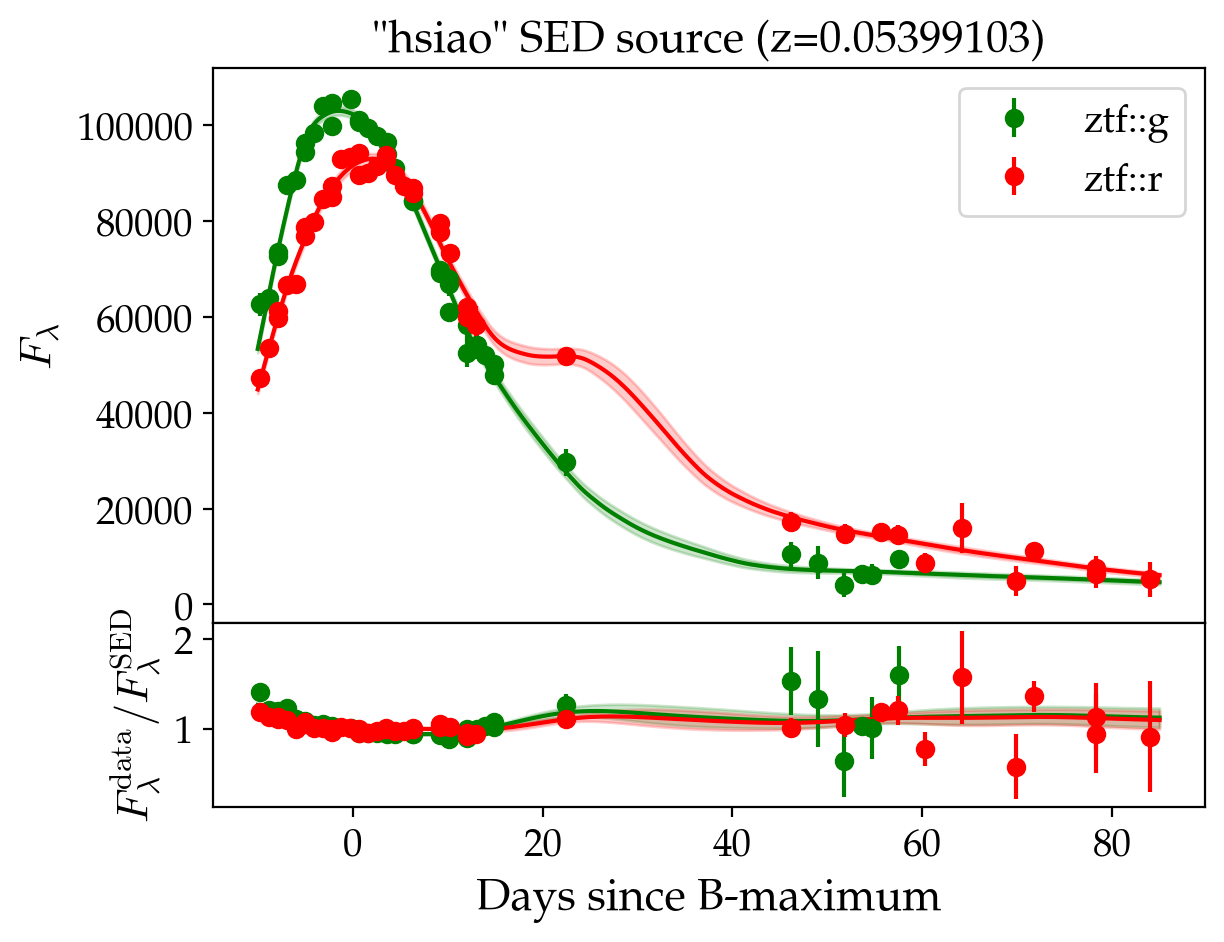

In [217]:
refiner.plot_fit()

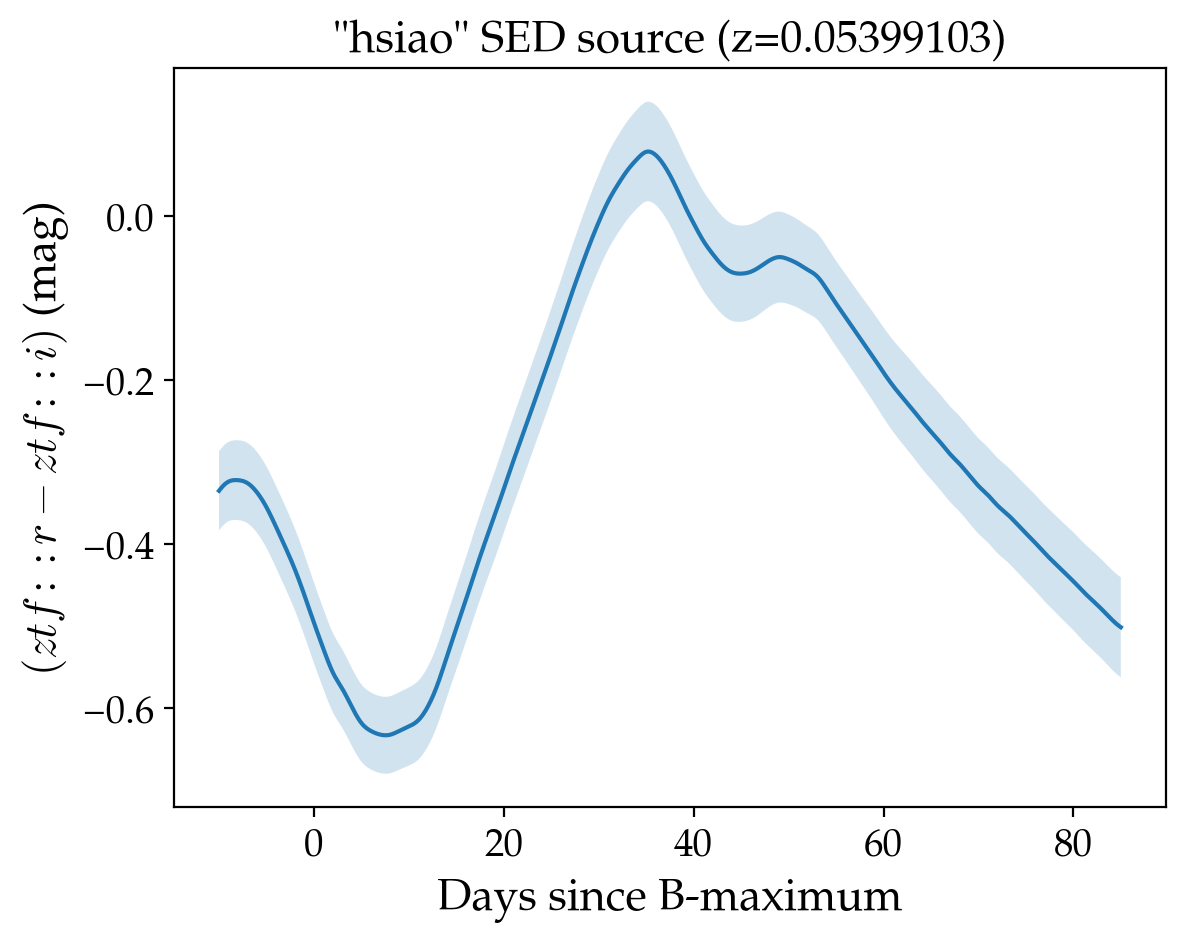

In [229]:
refiner.calculate_colour("ztf::r", "ztf::i")

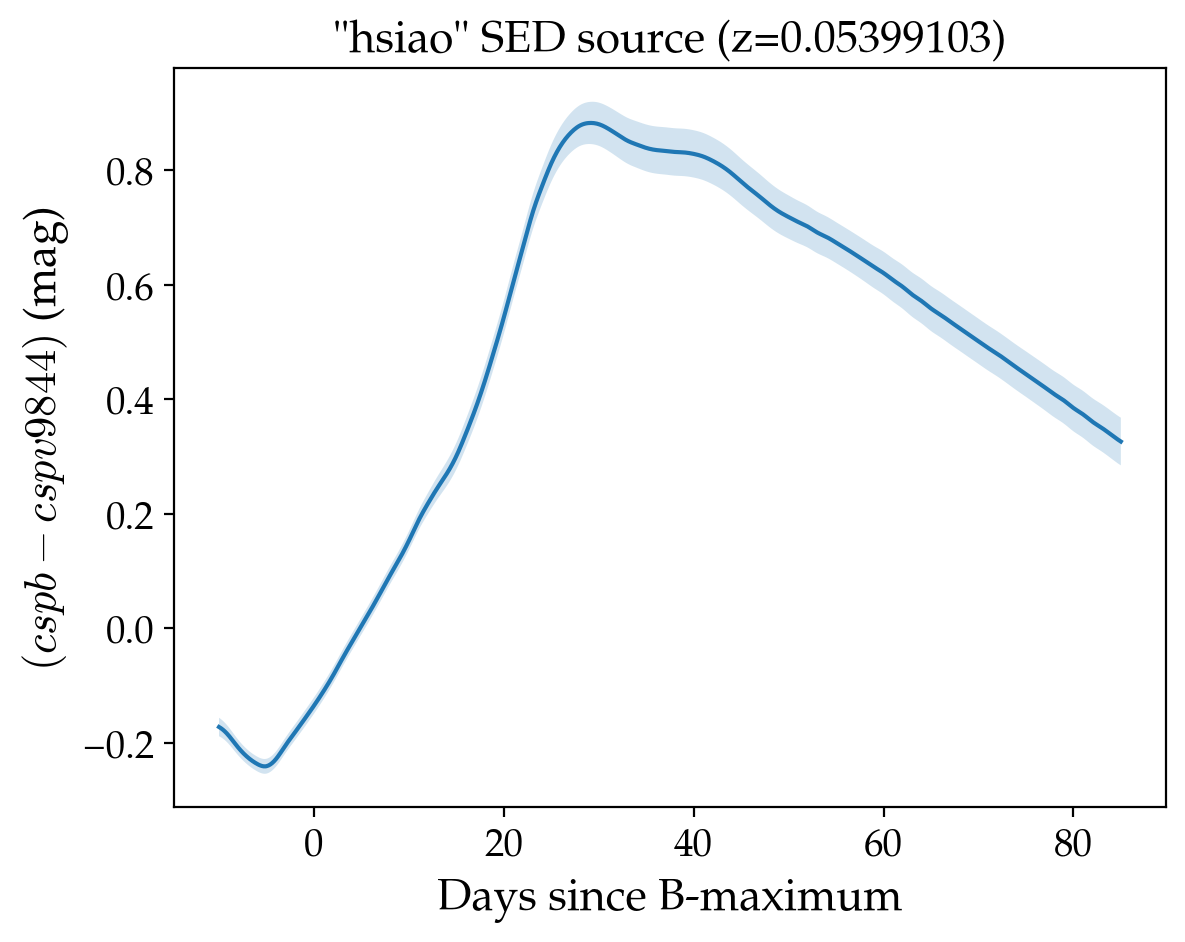

In [232]:
refiner.calculate_colour("cspb", "cspv9844")

In [203]:
# sBV between 0.4 and 1.4 translate to phases between 12 and 42 days
mask = (12 < refiner.pred_phase) & (refiner.pred_phase < 42)  
pred_phase = refiner.pred_phase[mask]
mask = np.array(list(mask) + list(mask))
fluxes = np.random.multivariate_normal(refiner.colour_flux_ratio[mask], 
                                       refiner.colour_flux_cov[np.ix_(mask, mask)], 
                                       size=1000)

In [205]:
# calculate mean and std
st_list = []
for flux in fluxes:
    N = len(flux) // 2
    f1 = flux[:N]
    f2 = flux[N:]
    flux_ratio = -2.5 * np.log10(f1 / f2)
    st_idx = np.argmax(flux_ratio)
    st_list.append(pred_phase[st_idx])
st, st_err = np.mean(st_list) / 30, np.std(st_list) / 30
st, st_err

(np.float64(1.0728233333333284), np.float64(0.1269658567839747))

In [108]:
np.mean(maxes) / 30, np.std(maxes) / 30

(np.float64(1.064199999999995), np.float64(0.11654242908819809))

In [134]:
from sncosmo.models import integration_grid, MODEL_BANDFLUX_SPACING, HC_ERG_AA

zp = 30
zpsys = "ab"
filt = "ztf::r"
band = sncosmo.get_bandpass(filt)
time = np.array([0.0])

pred_time = np.array([0.0] * len(band.wave))
mangling_surf, mangling_cov = refiner.gp_predict(pred_time, band.wave, return_cov=True)
mangling_std = np.sqrt(np.diag(mangling_cov))
flux_ = refiner.sed.rest_model.flux(time, band.wave)
flux = flux_[0] * mangling_surf
flux_err = flux_[0] * mangling_std

magsys = sncosmo.get_magsystem(zpsys)
zpnorm = 10.**(0.4 * zp)  / magsys.zpbandflux(filt)
_, dwave = integration_grid(band.minwave(), band.maxwave(), MODEL_BANDFLUX_SPACING)

F = np.sum(band.wave * band.trans * flux) * dwave / HC_ERG_AA  * zpnorm
#F_err = np.sum(band.wave * band.trans * flux_err) * dwave / HC_ERG_AA  * zpnorm
ones = (band.wave * band.trans * flux_[0]) * dwave / HC_ERG_AA  * zpnorm
F_err = np.sqrt(ones @ mangling_cov @ ones.T)

F, F_err

(np.float64(87778.13868274663), np.float64(700.8871123491296))

In [135]:
# get mangling value at the effective wavelength
idx = np.argmin(np.abs(band.wave -  band.wave_eff))
ms = mangling_surf[idx]
ms_err = mangling_std[idx]

bandflux_ = refiner.sed.rest_model.bandflux(filt, time, zp=zp, zpsys=zpsys) 
bandflux = bandflux_ * ms
bandflux_err = bandflux_ * ms_err
bandflux, bandflux_err

(array([87977.89934123]), array([747.49459387]))

In [136]:
F / bandflux, F_err / bandflux_err

(array([0.99772942]), array([0.9376484]))

In [133]:
F / F_err, bandflux / bandflux_err

(np.float64(105.68345783021799), array([110.74549358]))